In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import math
from sklearn.cluster import KMeans

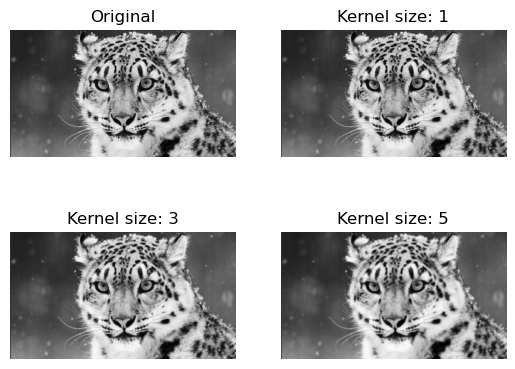

In [2]:
img1 = cv.imread('img1.jpg', cv.IMREAD_GRAYSCALE)

def apply_gaussian_noise(img, kernel_size=[1,3]):
    images = []
    for i in range(len(kernel_size)):
        noise = cv.GaussianBlur(img, (kernel_size[i], kernel_size[i]), 0)
        images.append(noise)
    return images

kernel_size = [1, 3, 5]
images = apply_gaussian_noise(img1, kernel_size)

for i in range(len(images)+1):
    plt.subplot(2, 2, i+1)
    if i == 0:
        plt.imshow(img1, cmap='gray')
        plt.title('Original')
    else:
        plt.imshow(images[i-1], cmap='gray')
        plt.title('Kernel size: ' + str(kernel_size[i-1]))
    plt.axis('off')
plt.show()

K must be less than sqrt(2), got K = 3.0
K must be less than sqrt(2), got K = 1.6666666666666667


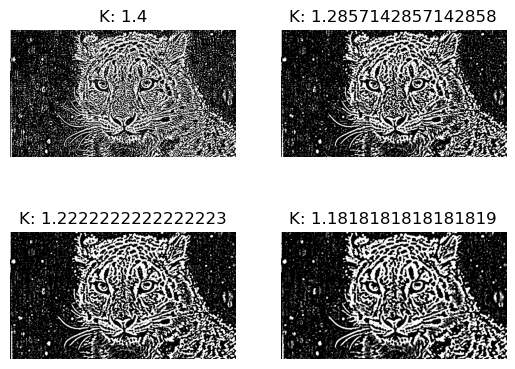

In [3]:
def L0G_func(K, image1, image2):
    if K < math.sqrt(2):
        image = image2 - image1
        return image
    else:
        print('K must be less than sqrt(2), got K =', K)
        return None

kernel_size = [1, 3, 5, 7, 9, 11, 13]

images = apply_gaussian_noise(img1, kernel_size)

LoG_images = []
for i in range(len(kernel_size)-1):
    K = kernel_size[i+1]/kernel_size[i]
    image = L0G_func(K, images[i], images[i+1])
    if image is not None:
        LoG_images.append({'image': image, 'K': K})

for i in range(len(LoG_images)):
    plt.subplot(2, 2, i+1)
    plt.imshow(LoG_images[i]['image'], cmap='gray')
    plt.title('K: ' + str(LoG_images[i]['K']))
    plt.axis('off')
plt.show()
    

Using diferent Kernels results in different images after applying LoG. In fact, the larger difference in kernel size, the less information is saved. This is because the LoG filter is a high-pass filter, which means that it removes low-frequency information from the image. This is why the image is blurred after applying the filter. The smaller the Kernel size difference, we have more information and less edge detection.

In [4]:
def get_SIFT_keypoints(image, nfeatures=0,
                 contrastThreshold=0.04, edgeThreshold=10, sigma=1.6):
    sift = cv.SIFT_create(nfeatures=nfeatures,
                            contrastThreshold=contrastThreshold,
                            edgeThreshold=edgeThreshold,
                            sigma=sigma)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def draw_SIFT_keypoints(image, keypoints):
    image = cv.drawKeypoints(image, keypoints, None)
    return image

def handle_keypoints(image):
    images = []
    parameters = {'contrastThreshold': 0.02, 'edgeThreshold': 5, 'sigma': 1}
    for ct_multiplier in [1, 2]:
        for et_multiplier in [1, 2]:
            for sigma_multiplier in [1, 2]:
                params = {
                    'contrastThreshold': parameters['contrastThreshold'] * ct_multiplier,
                    'edgeThreshold': parameters['edgeThreshold'] * et_multiplier,
                    'sigma': parameters['sigma'] * sigma_multiplier
                }
                keypoints, descriptors = get_SIFT_keypoints(image, **params)
                image_with_keypoints = draw_SIFT_keypoints(image, keypoints)
                images.append({'image': image_with_keypoints, 'params': params})
    return images

8


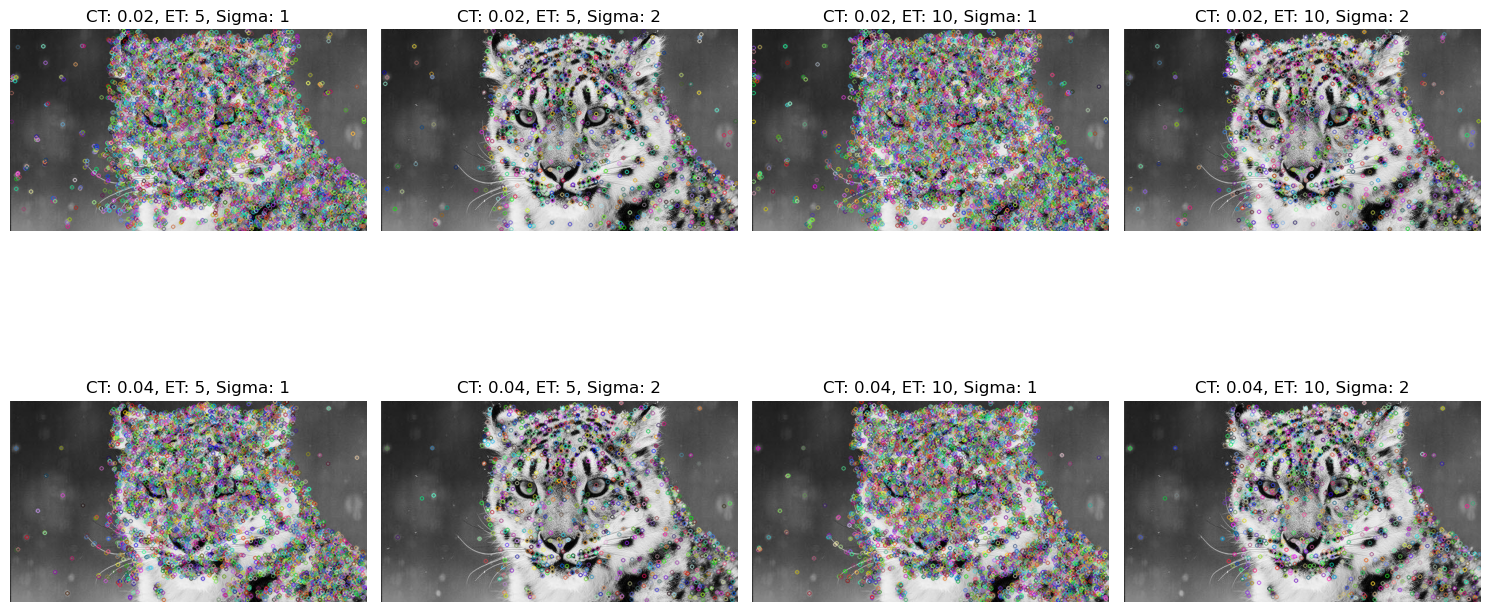

In [5]:
images1 = handle_keypoints(img1)

print(len(images1))
fig = plt.figure(figsize=(15, 15))
for i in range(len(images1)):
    plt.subplot(4, 4, i+1)
    plt.imshow(images1[i]['image'], cmap='gray')
    plt.title(f"CT: {images1[i]['params']['contrastThreshold']}, "
              f"ET: {images1[i]['params']['edgeThreshold']}, "
              f"Sigma: {images1[i]['params']['sigma']}")
    plt.axis('off')
plt.tight_layout()
plt.show()

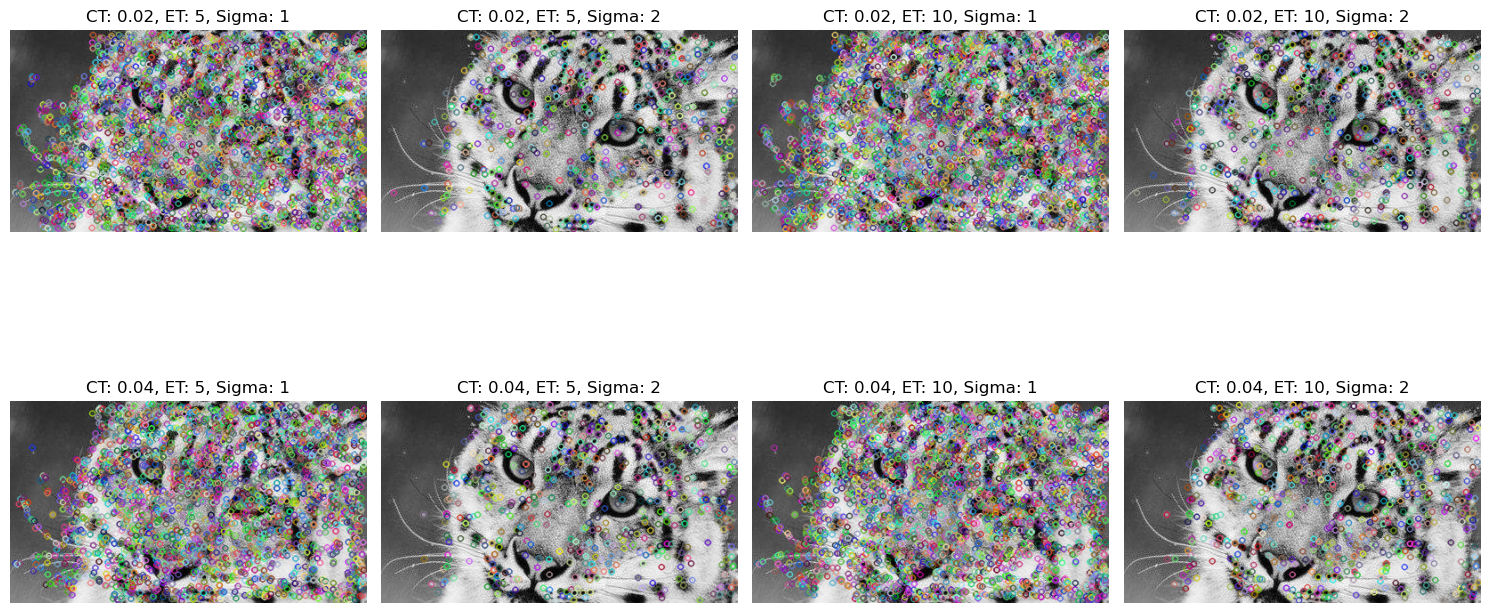

In [6]:
image2 = cv.imread('img2.jpg', cv.IMREAD_GRAYSCALE)

images2 = handle_keypoints(image2)

fig = plt.figure(figsize=(15, 15))
for i in range(len(images2)):
    plt.subplot(4, 4, i+1)
    plt.imshow(images2[i]['image'], cmap='gray')
    plt.title(f"CT: {images2[i]['params']['contrastThreshold']}, "
              f"ET: {images2[i]['params']['edgeThreshold']}, "
              f"Sigma: {images2[i]['params']['sigma']}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### SIFT Parameters and Their Effects

1. **$ \sigma $ (Sigma)**:  
   - Controls image smoothing in scale-space.  
   - **Increase**: Fewer keypoints; captures larger-scale features; less noise.

2. **$ C_T $ (Contrast Threshold)**:  
   - Filters out low-contrast keypoints.  
   - **Increase**: Fewer keypoints; emphasizes stable, high-contrast features.

3. **$ E_T $ (Edge Threshold)**:  
   - Rejects keypoints along edges.  
   - **Increase**: More keypoints, including edge-like ones; less stability.

As obvious from results, the choice of parameters has a significant impact on the number and quality of keypoints detected. Maybe I had to use a littel bit small sigma increasement, but I think it is still able to detect keypoints.

574


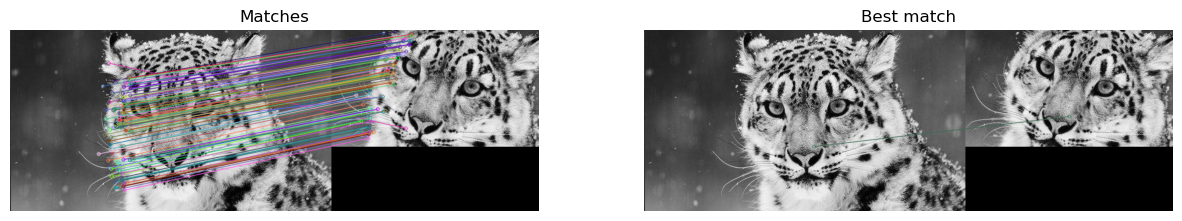

In [7]:
def get_matches(descriptors1, descriptors2, treshold=0.75):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    good = []
    best_match = []
    best_match_got = 100

    for m, n in matches:
        if m.distance < treshold * n.distance:
            good.append([m])
            if m.distance < best_match_got:
                best_match_got = m.distance
                best_match = [m]
    return good, best_match

def draw_matches(image1, image2, keypoints1, keypoints2, matches):
    image = cv.drawMatchesKnn(image1, keypoints1, image2, keypoints2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return image

key_points_img1, descriptors_img1 = get_SIFT_keypoints(img1)
key_points_img2, descriptors_img2 = get_SIFT_keypoints(image2)

matches, best_match = get_matches(descriptors_img1, descriptors_img2)

print(len(matches))

image = draw_matches(img1, image2, key_points_img1, key_points_img2, matches[:100])

best_image = draw_matches(img1, image2, key_points_img1, key_points_img2, [best_match])

fig = plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Matches')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(best_image)
plt.title('Best match')
plt.axis('off')
plt.show()

Here I've got 574 keypoint matches between the two images, however TA suggested to plot only 100 of them. The closest match is tigers nose, which makes sence of course. When plotting 100 keypoints, I see that the background is not matching well, but the tiger's face is matching well. This is a good sign of course, as it was our initial goal to detect the tiger's face.

In [8]:
img3 = cv.imread('img3.jpg', cv.IMREAD_GRAYSCALE)

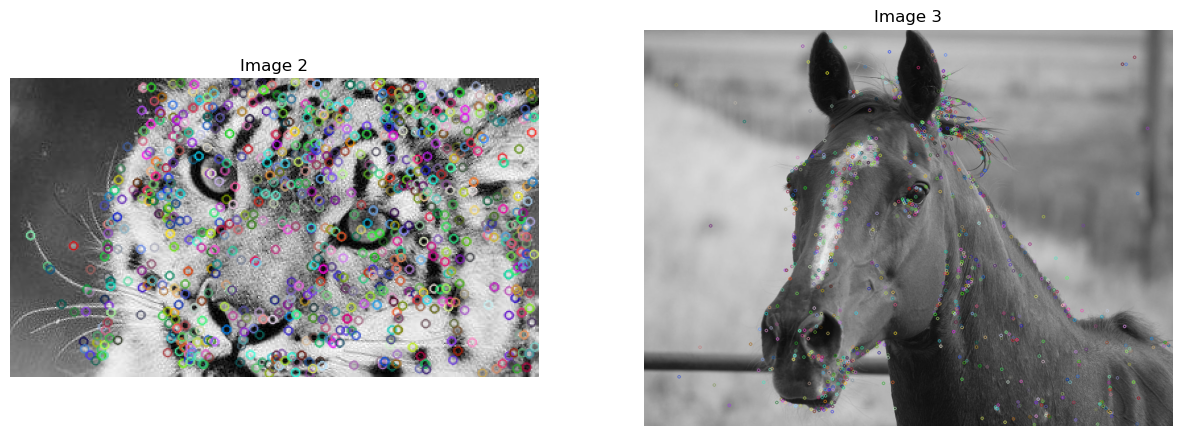

In [9]:
# Get 1000 keypoints
key_points_img2, descriptors_img2 = get_SIFT_keypoints(image2, nfeatures=1000)
key_points_img3, descriptors_img3 = get_SIFT_keypoints(img3, nfeatures=1000)

fig = plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(draw_SIFT_keypoints(image2, key_points_img2), cmap='gray')
plt.title('Image 2')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(draw_SIFT_keypoints(img3, key_points_img3), cmap='gray')
plt.title('Image 3')
plt.axis('off')
plt.show()

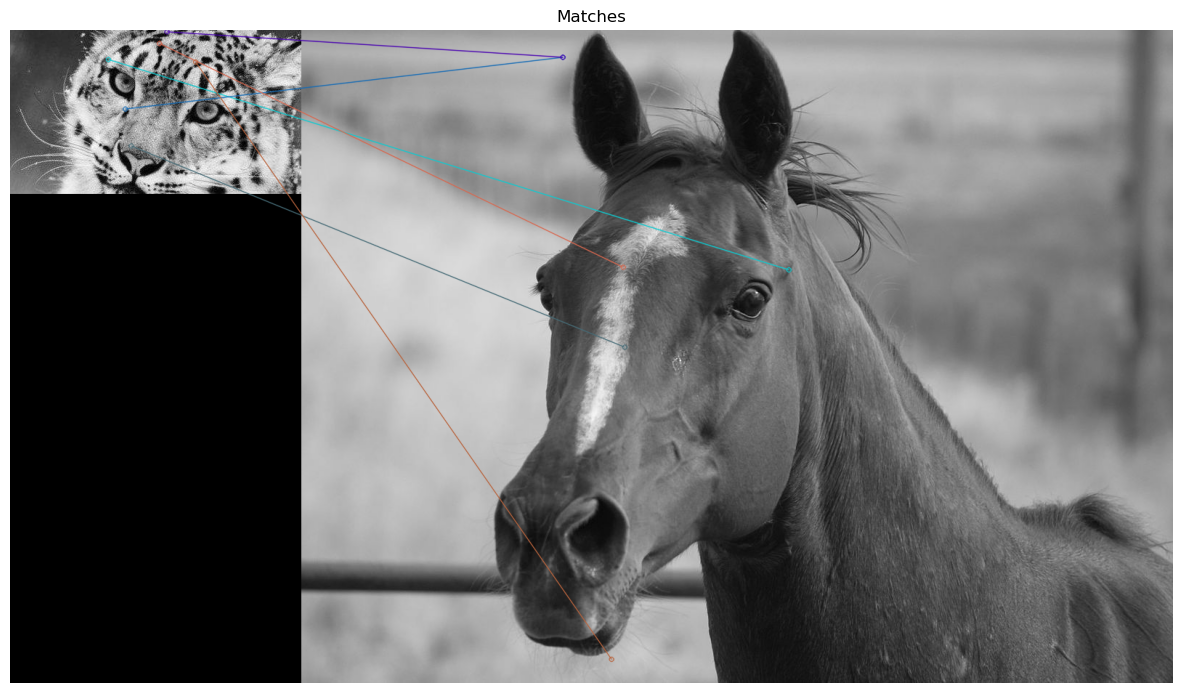

In [ ]:
image = draw_matches(image2, img3, key_points_img2, key_points_img3, good_matches)

fig = plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.title('Matches')
plt.axis('off')
plt.show()

In [16]:
descriptors = np.concatenate((descriptors_img2, descriptors_img3), axis=0)

k = 10

kmeans = KMeans(n_init=10, n_clusters=k)
kmeans.fit(descriptors)

cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


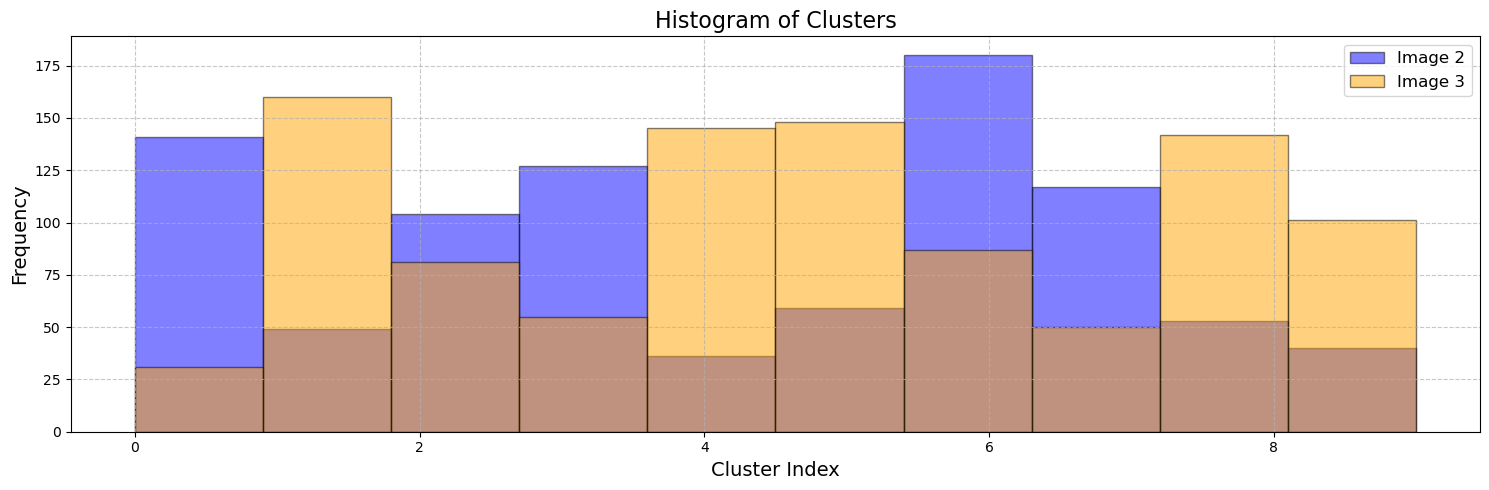

In [ ]:
cluster_img2 = kmeans.predict(descriptors_img2)
cluster_img3 = kmeans.predict(descriptors_img3)

fig, ax = plt.subplots(figsize=(15, 5))

ax.hist(cluster_img2, bins=k, alpha=0.5, label='Image 2', color='blue', edgecolor='black')
ax.hist(cluster_img3, bins=k, alpha=0.5, label='Image 3', color='orange', edgecolor='black')

ax.set_title('Histogram of Clusters', fontsize=16)
ax.set_xlabel('Cluster Index', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

ax.legend(loc='upper right', fontsize=12)

ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



As predicted, there is not well correlation between the keypoints of the two images. This is because the images are not taken from the same, or similar, angles. The keypoints are not matching well, because the keypoints are not matching well.

### Expanding Our Method for Different Images

1. **Image Preprocessing**  
   - Convert images to grayscale for compatibility with SIFT.  

2. **Feature Detection with SIFT**  
   - **Initialize Detector:** Configure SIFT parameters (e.g., number of features, contrast threshold).  
   - **Detect Keypoints & Compute Descriptors:** Identify scale/rotation-invariant keypoints and their descriptors for both images.  

3. **Feature Matching with KNN**  
   - **Set Up Matcher:** Use a KNN-compatible matcher (e.g., Brute-Force Matcher).  
   - **Perform Matching:** Match descriptors using k-nearest neighbors (commonly `k=2`).  
   - **Apply Ratio Test:** Filter matches using Lowe's ratio test (e.g., threshold = 0.75) to reduce false positives.  
